# PPR Crime Statistics Model Using ArcGIS Notebooks

This Notebook uses Arcpy to catch the crime points throughout the year that fall within 5ft of each PPR property. These points are then spatially joined to PPR properties for analysis and reporting.

## 1. IMPORTANT: Before Running the Code

<b><font color="red">IMPORTANT: Manually load the PPD crime point feature from DataBridge (called ``GIS_POLICE.INCIDENTS_PART1_PART2``) into this project before running any code below!
    
Using the date field, manually set a definition query to include only the crimes that occurred in the year that you are generating the report for. Keep the feature name the same.</font></b>

There are numerous times throughout the code where you will have to change a path or layer name. These instances have bolded messages in red that come just before the cell you need to change. If you are ever unsure of what line within the cell the message is referencing, there is a ``#CHANGE!`` note after the line that needs to be changed within the cell.

## 2. Load the necessary libraries and set your workspace.

The cell below imports the necessary libraries - in this case, we need the Operating System library and ArcPy. This cell will need to be re-run every time you re-open the Notebook in order for the code to work.

In [ ]:
# The import statements load each module
import os
import arcpy # Best practice: Load arcpy last to maintain priority for namespace

The cell below establishes the active ArcGIS Project that the code is linked to. In this case, it is the current Pro project and the first Map (titled ``Map``) that we are getting our data from.

In [ ]:
aprx = arcpy.mp.ArcGISProject("CURRENT")
mp = aprx.listMaps('Map')[0] # first map in project - mine is titled "Map"

The cells below establish our default file geodatabase and the dataset within the geodatabase - this is where all of our outputs will be saved to.

<b><font color='red'>IMPORTANT: CHANGE THE FGDB LINE BELOW TO THE CURRENT SECONDARY GEODATABASE WHEN READY. ALSO CHANGE THE ARCPY ENVIRONMENT LINE TO THE CORRECT DATASET WITHIN THE CURRENT SECONDARY GEODATABASE.</font></b>

In [ ]:
# Create a variable that represents the default file geodatabase
fgdb = r'X:\Secondary_2021.gdb' #CHANGE! This is the geodatabase
aprx.defaultGeodatabase = fgdb # setting your fgdb as the default

arcpy.env.workspace = r'X:\Secondary_2021.gdb\Crime_2022_Data' #CHANGE! This is the geodatabase dataset you are working in
arcpy.env.overwriteOutput=True # this allows you to overwrite files that are already in the geodatabase if you need to

## 3. Copy ``PPR_Properties`` to the fgdb

The cells below are reading our properties shapefile using its path. You can always use this method to bring in data that is not already in our Contents Pane. The second cell makes a copy of this feature and saves it to our desired file geodatabase.

<b><font color='red'>IMPORTANT: CHANGE THE PROPERTIES NAME FROM BETA WHEN IT IS MADE PERMANENT.</font></b>

In [ ]:
PPR_Properties = r'X:\PPR_GIS_Data.gdb\Asset_Data\PPR_Properties_BETA' #CHANGE!

<b><font color='red'>IMPORTANT: CHANGE THE PATH IN THE NEXT CELL BLOCK TO COPY THE PROPERTIES FEATURE TO THE CURRENT SECONDARY GEODATABASE.</font></b>

Below is a guide to changing the path name, as the first and last path levels can remain the same but the second and third levels must be changed to represent the current geodatabase and dataset. Make sure you keep the quotation marks before and after the path.<br>


</br>
<div>
    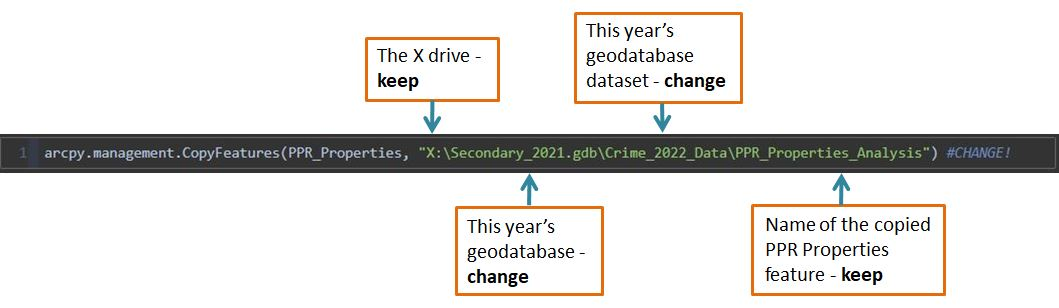
</div>


In [ ]:
arcpy.management.CopyFeatures(PPR_Properties, "X:\Secondary_2021.gdb\Crime_2022_Data\PPR_Properties_Analysis") #CHANGE!
                                            # ^ KEEP   ^ CHANGE          ^ CHANGE        ^ KEEP

The cell below sets a definition query for our properties feature so that only our predetermined crime analysis properties will be used.

In [ ]:
for lyr in mp.listLayers("PPR_Properties_Analysis"):
    lyr.definitionQuery = "CRIME_ANALYSIS = 'Y'"
    
PPR_Properties = "PPR_Properties_Analysis"

## 4. Buffer 5 feet from each property

ArcPy's buffer tool will be used to create a simple 5-foot buffer around our properties to catch the crimes that fall close to the properties. The output of this cell will be a buffer feature titled "PPR_Buffer". Watch it get added to the Contents Pane and the map.

In [ ]:
arcpy.Buffer_analysis(PPR_Properties, "PPR_Buffer", "5 Feet")

## 5. Copy the crime data

The crime data should have already been copied from DataBridge and put into this ArcGIS Pro project. To save processing time and power, manually set a definition query to include only crimes that have occurred this year; however, a cell below runs this query again to make sure you have done this. 

In [ ]:
crime = "GIS_POLICE.INCIDENTS_PART1_PART2" 
arcpy.CopyFeatures_management(crime, 'crime')

We're setting another definition query to ensure that the feature only includes crimes that have occurred this year.

<b><font color='red'>IMPORTANT: CHANGE THE DATES BELOW TO THE ANALYSIS YEAR.</font></b>

In [ ]:
for lyr in mp.listLayers("crime"):
    lyr.definitionQuery = "DISPATCH_DATE >= '2021-01-01' AND DISPATCH_DATE <= '2021-12-31'" #CHANGE!

We're selecting only the crime points that intersect our properties buffer; all other crimes are not necessary to keep since we are only focusing on PPR properties. The output of this cell will be a new layer in the Contents Pane and map titled ``crime_buffzone``.

In [ ]:
selection = arcpy.SelectLayerByLocation_management("crime", "INTERSECT", "PPR_Buffer")
arcpy.CopyFeatures_management(selection, "crime_buffzone") # add this selection as a new layer to Pro

## 6. Add the new crime data fields

The cell below is the same as manually adding a new field to a feature, but we can add many at once and still specify the field name, type, and length. You can check the "crime_buffzone" feature for the empty added fields after running the cell below.

In [ ]:
arcpy.management.AddField("crime_buffzone", "GIS_PART", "TEXT", 50)
arcpy.management.AddField("crime_buffzone", "GIS_CRIME", "TEXT", 50)
arcpy.management.AddField("crime_buffzone", "SEASON", "TEXT", 10)
arcpy.management.AddField("crime_buffzone", "ACTIVE_HOURS", "TEXT", 10)

## 7. Populate the GIS_PART field

The cells below are the same as manually using the Field Calculator to determine values for one field based on another. You have your code block (which should be very similar to that in the Field Calculator), your table/feature parameters, the field that you are populating, the expression to go along with your code block and the function you defined, and then the actual ArcPy Calculate Field command.

In [ ]:
codeblock="""def fnPart(UCR_GENERAL):
  if int(UCR_GENERAL) <= 400:
    return "Part 1 Violent Crime"
  elif int(UCR_GENERAL) >= 500 and int(UCR_GENERAL) <= 700:
    return "Part 1 Property Crime"
  elif int(UCR_GENERAL) > 700:
    return "Part 2 Crime" """
inTable = "crime_buffzone"
fieldName = "GIS_PART"
expression = "fnPart(!UCR_GENERAL!)"

In [ ]:
arcpy.CalculateField_management(inTable, fieldName, expression, "PYTHON", codeblock)

You should now see that this field is populated in your feature table. The below sections are the same as above but with different fields.

## 8. Populate the GIS_CRIME field

In [ ]:
codeblock2="""def fnCrime(UCR_GENERAL):
  if UCR_GENERAL == "100":
    return "Homicide"
  elif UCR_GENERAL == "200":
    return "Rape"
  elif UCR_GENERAL == "300":
    return "Robbery"
  elif UCR_GENERAL == "400":
    return "Aggravated Assault"
  elif UCR_GENERAL == "500":
    return "Burglary"
  elif UCR_GENERAL == "600":
    return "Theft"
  elif UCR_GENERAL == "700":
    return "Motor Vehicle Theft"
  elif UCR_GENERAL == "800":
    return "Simple Assault"
  elif UCR_GENERAL == "900":
    return "Arson"
  elif UCR_GENERAL == "1000":
    return "Forgery and Counterfeiting"
  elif UCR_GENERAL == "1100":
    return "Fraud"
  elif UCR_GENERAL == "1200":
    return "Embezzlement"
  elif UCR_GENERAL == "1300":
    return "Receiving Stolen Property"
  elif UCR_GENERAL == "1400":
    return "Vandalism"
  elif UCR_GENERAL == "1500":
    return "VUFA (Violation of the Uniform Firearm Act)"
  elif UCR_GENERAL == "1600":
    return "Prostitution and Commercialized Vice"
  elif UCR_GENERAL == "1700":
    return "Other Sex Offenses"
  elif UCR_GENERAL == "1800":
    return "Narcotics/Drug Law Violations"
  elif UCR_GENERAL == "1900":
    return "Gambling Violations"
  elif UCR_GENERAL == "2000":
    return "Offenses Against Family and Children"
  elif UCR_GENERAL == "2100":
    return "Driving Under the Influence (DUI)"
  elif UCR_GENERAL == "2200":
    return "Liquor Law Violations"
  elif UCR_GENERAL == "2300":
    return "Public Drunkenness"
  elif UCR_GENERAL == "2400":
    return "Disorderly Conduct"
  elif UCR_GENERAL == "2500":
    return "Vagrancy/Loitering"
  elif UCR_GENERAL == "2600":
    return "All Other Offenses" """
fieldName2 = "GIS_CRIME"
expression2 = "fnCrime(!UCR_GENERAL!)"

In [ ]:
arcpy.CalculateField_management(inTable, fieldName2, expression2, "PYTHON", codeblock2)

## 9. Populate the Season field

In [ ]:
codeblock3 = """def fnSeason(DISPATCH_DATE):
  Dis_Date_NEW = DISPATCH_DATE[5:]
  if Dis_Date_NEW >= "07-01" and Dis_Date_NEW <= "08-31":
    return "Summer"
  else:
    return "Off-Season" """
fieldName3 = "SEASON"
expression3 = "fnSeason(!DISPATCH_DATE!)"

In [ ]:
arcpy.CalculateField_management(inTable, fieldName3, expression3, "PYTHON", codeblock3)

## 10. Populate the Crime Hour field

In [ ]:
codeblock4 = """def fnActive(SEASON, HOUR_):
  if SEASON == "Summer" and HOUR_ >= 9 and HOUR_ <= 22:
    return "Active"
  elif SEASON == "Off-Season" and HOUR_ >= 13 and HOUR_ <= 22:
    return "Active"
  else:
    return "Non-Active" """
fieldName4 = "ACTIVE_HOURS"
expression4 = "fnActive(!SEASON!, !HOUR_!)"

In [ ]:
arcpy.CalculateField_management(inTable, fieldName4, expression4, "PYTHON", codeblock4)

## 11. Spatial Join

Now that our feature has all the fields we need to create our report, we are going to join it to our buffered PPR properties feature.

In [ ]:
arcpy.analysis.SpatialJoin("crime_buffzone", "PPR_Buffer", "PPR_Crime_5ft", 'JOIN_ONE_TO_MANY')

## 12. Find and Select Duplicate Crimes & Crimes in Multiple Districts

Since nested properties have been incorporated into this analysis in the past, there have been issues with duplicate properties being listed with different crime counts as a result of the spatial join. The cells below just ensure that any duplicates are marked so they could be deleted.

In [ ]:
arcpy.management.AddField("PPR_Crime_5ft", "Dup", "SHORT", 5)

In [ ]:
codeblock_sp = """
uniqueList = {}

fc = "PPR_Crime_5ft"
rows = arcpy.SearchCursor(fc)

for row in rows:
    value = row.getValue("TARGET_FID")
    if value not in uniqueList:
        uniqueList[value] = 1
    else:
        uniqueList[value] = uniqueList[value] + 1
        
def findIncidence(inValue):
    return uniqueList[inValue] """
fieldName_sp = "Dup"
expression_sp = "findIncidence(!TARGET_FID!)"

In [ ]:
arcpy.CalculateField_management("PPR_Crime_5ft", fieldName_sp, expression_sp, "PYTHON", codeblock_sp)

<b><font color="red">IMPORTANT: Check the "Dup" field for any duplicate properties.</font></b>

Duplicates will be marked with a value of 2 or higher depending on how many duplicates there are. Manually go through them in the attribute table and <b>determine which should be deleted (sites that are not nested, typically)</b>.

<b><font color="red">IMPORTANT: Also be sure to <b>manually change any fields that are have multiple council districts listed for them!</font></b>

</b> The district that the majority of the site sits in should be the single district listed for the site (e.g., Hunting Park as 5,7 should be 5 since it is mostly in District 5). If two districts are listed for a large property such as Cobbs Creek Park, the district that the crime point is located within should be chosen as the district. If a crime occurred on the boundary between two districts, ask Chris about which district should be chosen.

## 13. Export Tables to CSV

Before we save our data to a CSV, make sure that any crime points that may have been selected 

Let's save all of our raw crime data to a CSV file so that we have an internal Excel version of our complete data analysis. If anyone asks for the Excel verson, Chris will clean up the data before sharing it.

<b><font color="red">IMPORTANT: CHANGE THE NAMES OF THE TABLE OUT PATH AND NAME IN THE CELL BELOW TO SPECIFY THIS YEAR'S PROJECT FOLDER AND YEAR FOR THE OUTPUT TABLE.</font></b>

In [ ]:
table_out_path = r"X:\Projects\Special_Projects\Crime\Crime_Statistics\2021_AnnualStats_PPRSystem" #CHANGE! This is your project folder path
table_out_name = "crimeanalysis2021_allPPR.csv" # CHANGE! The 2021 should be changed to represent the year of the report.

In [ ]:
arcpy.conversion.TableToTable("PPR_Crime_5ft", table_out_path, table_out_name)

## 14. Delete Unnecessary Files from Geodatabase

To clean up our feature dataset within our default geodatabase, we're going to delete files that we no longer need.

<b><font color="red">IMPORTANT: CHANGE THE PATH NAMES BELOW TO REPRESENT THIS YEAR'S LAYERS.</font></b> The path names below should only have the geodatabase and dataset levels (the 2nd and 3rd levels in the path name) changed to represent the current geodatabase and dataset; the last level of the paths should remain the same, as this is the name of the feature that you have created.

In [ ]:
deletes = [r'X:\Secondary_2021.gdb\Crime_2022_Data\crime_buffzone', r'X:\Secondary_2021.gdb\Crime_2022_Data\PPR_Buffer'] #CHANGE ALL PATH NAMES!
for delete in deletes:
    arcpy.Delete_management(delete) # referencing the path deletes it from the geodatabase/source as well as from the Pro project
arcpy.Delete_management("GIS_POLICE.INCIDENTS_PART1_PART2") # referencing just the name deletes it from the Pro project but not from source

Return to the Word guide to read more about the Crime Report Notebook. When you move on to running the Crime Report Notebook, make sure it is in the same Pro project with the layer that you produced (``PPR_Crime_5ft``) in the Contents Pane, as you will be calling this same layer for your visualizations.